In [1]:
##########################
###Package dependencies###
##########################
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns

In [5]:
#########################
###Data Import Methods###
#########################

#Create Dictionary from a row element of input data
def makeRowToDict(row):
    #search_term,newspaper_domain,startdate,enddate,date,response_id,url,matchtype,matchedserch_term,
    #party,member,entitytype,text,levenshtein,sentiment,relevance,count,sentiment_id
    mydict = dict(search_term=row[0],
                  newspaper=row[1],
                  startdate=row[2], enddate=row[3], date=row[4],
                  response_id=row[5], url=row[6],
                  match_type=row[7],
                  politician=row[8], party=row[9], role=row[10], entity_type=row[11], entity_text=row[12], levenshtein=row[13],
                  sentiment=float(row[14]), relevance=float(row[15]), count=int(row[16]),
                  sentiment_id=row[17])
    return mydict

#Create Dataframe from all inputfiles
def createDataFrame(filenames):
    sentimentlist = []
    #Read all Data for Analysis
    for i in filenames:
        print("Importing: " + i)
        filestring = i + "_politicalsentiments.csv"
        file = open(os.path.join(inputpath, filestring), "rU")
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            if not row[0] == "search_term":
                #print(row[10])
                sentimentlist.append(makeRowToDict(row))
    return pd.DataFrame(sentimentlist)

def subsample(df, pct=0.9):
    N = len(df)
    indexer = np.sort(np.random.permutation(N)[:int(pct*N)])
    return df.loc[indexer,]

def getparty(politician):
    global df
    return df.loc[df['politician'] == politician, 'party'].iloc[0]

def getText(politician, match_type):
    global df
    return df[(df['politician'] == politician) & (df['match_type'] == match_type)]['entity_text']

def savedf(df, name):
    df.to_csv(outputpath + name + '.csv', sep=';')

In [4]:
#################
###Data Import###
#################

#Parameters for loading and saving data
savename = 'politicalparties'
filenames = ['pnp1', 'pnp2', 'pnp3', 'fr', 'ntv', 'stern', 'taz', 'tagesschau', 'jungewelt', 'jungefreiheit', 'postillon', 'zeit', 'spiegel',
             'bild', 'tagesspiegel', 'huffington', 'handelsblatt', 'focus', 'welt', 'sueddeutsche', 'faz']

#filenames = ['pnp1', 'pnp2', 'pnp3', 'focus']

savefigures = False
inputpath = os.getcwd() + "/Input"
outputpath = os.getcwd() + "/Output/"

dforiginal = createDataFrame(filenames)

Importing: pnp1


/Users/Julian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 'U' mode is deprecated


Importing: pnp2
Importing: pnp3
Importing: fr
Importing: ntv
Importing: stern
Importing: taz
Importing: tagesschau
Importing: jungewelt
Importing: jungefreiheit
Importing: postillon
Importing: zeit
Importing: spiegel
Importing: bild
Importing: tagesspiegel
Importing: huffington
Importing: handelsblatt
Importing: focus
Importing: welt
Importing: sueddeutsche
Importing: faz


In [8]:
######################
###Data Preparation###
######################
def preparedata(dforiginal):
    #Subsample to reduce amount of data
    df = subsample(dforiginal, 1)

    #format of dates, make date the index
    df["date"] = df["date"].astype("datetime64[ns]")
    df["startdate"] = df["startdate"].astype("datetime64[ns]")
    df["enddate"] = df["enddate"].astype("datetime64[ns]")
    df = df.sort_values(ascending=False, by=['date'])
    df["index"] = df["date"]
    df = df.set_index('index')
    df.levenshtein = df.levenshtein.replace('NaN', -1)
    df.levenshtein = df.levenshtein.astype('int64')
    df.party = df.party.replace('Bündnis 90/Die Grünen', 'Die Grünen')

    #Introduce date as an integer in order to perform regressions/correlations later
    df['datetimedelta'] = pd.to_timedelta(df['date'])
    df['datetimedelta'] = df['datetimedelta'] - df.datetimedelta.min()
    df["datetimedelta"] = df["datetimedelta"].astype("int")/(3600*24*1000000000)

    #Introduce categorical sentiment
    bins = [-1.000000001, -0.000000001, 0.000000001, 1.000000001]
    group_names = ['negative','neutral','positive']
    df['sentimentcategory'] = pd.cut(df['sentiment'], bins, labels=group_names)


    #Remove www.<>.de from newspapers
    df["newspaper_domain"] = df["newspaper"]
    newspapernames = [['www.afdkompakt.de','AfDkompakt'],
                        ['www.bayernkurier.de','Bayernkurier'],
                        ['www.bild.de','Bild'],
                        ['www.der-postillon.com','Der-Postillon'],
                        ['www.faz.net','FAZ'],
                        ['www.focus.de','Focus'],
                        ['www.fr.de','FR'],
                        ['www.gruene.de','Gruene.de'],
                        ['www.handelsblatt.de','Handelsblatt'],
                        ['www.huffingtonpost.de','Huffingtonpost'],
                        ['www.jungefreiheit.de','JungeFreiheit'],
                        ['www.jungewelt.de','JungeWelt'],
                        ['www.n-tv.de','N-TV'],
                        ['www.national-zeitung.de','National-Zeitung'],
                        ['www.neues-deutschland.de','Neues-Deutschland'],
                        ['www.spiegel.de','Spiegel'],
                        ['www.stern.de','Stern'],
                        ['www.sueddeutsche.de','Sueddeutsche'],
                        ['www.tagesschau.de','Tagesschau'],
                        ['www.tagesspiegel.de','Tagesspiegel'],
                        ['www.taz.de','TAZ'],
                        ['www.unsere-zeit.de','Unsere-Zeit'],
                        ['www.vorwaerts.de','Vorwaerts'],
                        ['www.welt.de','Welt'],
                        ['www.zeit.de','Zeit']]
    for paper in newspapernames:
        print("Change " + paper[0] + " to " + paper[1])
        df.newspaper = df.newspaper.replace(paper[0], paper[1])
    return df

In [ ]:
meancorrdf = df.groupby(['newspaper'])['sentimentoriginal'].mean()

correctiondf = pd.DataFrame({'Original Sentiment': meandf, 'Correction Margin': newspmeancorr, 'Corrected': withoutbias})
correctiondf = correctiondf.sort_values(by=['Original Sentiment'])
fig, ax = plt.subplots(figsize=(14,5))
fig.subplots_adjust(left=0.05, bottom=0.3, right=0.95, top=0.98,
                        wspace=None, hspace=None)
correctiondf.plot(kind='bar', ax=ax)
plt.savefig("Output/meancorrection.pdf")

In [6]:
##########################
###Data Preprocessing 1###
##########################

#Remove newspapers with to view observations
print("Sentiments before processing: " + str(len(df)))

df = df[df['newspaper'] != 'www.fdplus.de']
df = df[df['newspaper'] != 'www.union-magazin.de']

#Remove Politicians with less than 300 total observations
allpoliticians = df.groupby(['politician']).size()
removeablepoliticians = allpoliticians.index[allpoliticians < 200]
removeablepoliticianslist = removeablepoliticians.tolist()

for pol in removeablepoliticianslist:
    print("Removing: " + pol)
    df = df[df['politician'] != pol]


print("Sentiments after processing: " + str(len(df)))

Sentiments before processing: 1258371
Removing: Achim Kessler
Removing: Agnes Alpers
Removing: Albert Rupprecht
Removing: Albert Stegemann
Removing: Alexander Hoffmann
Removing: Alexander Krauß
Removing: Alexander Kulitz
Removing: Alexander Müller
Removing: Alexander Radwan
Removing: Alexander Throm
Removing: Alexandra Dinges-Dierig
Removing: Ali Al-Dailami
Removing: Alois Georg Josef Rainer
Removing: Alois Gerig
Removing: Amira Mohamed Ali
Removing: Andrea Lindholz
Removing: Andrea Wicklein
Removing: Andreas Bleck
Removing: Andreas Jung
Removing: Andreas Lämmel
Removing: Andreas Mattfeldt
Removing: Andreas Mrosek
Removing: Andreas Rimkus
Removing: Andreas Schockenhoff
Removing: Andreas Steier
Removing: Andrej Hunko
Removing: Andrew Ullmann
Removing: Anette Hübinger
Removing: Anette Kramme
Removing: Angelika Glöckner
Removing: Angelika Niebler
Removing: Anja Hajduk
Removing: Anja Weisgerber
Removing: Anke Domscheit-Berg
Removing: Anna Christmann
Removing: Annette Groth
Removing: Annett

Removing: Karl A. Lamers
Removing: Karl Holmeier
Removing: Karl Schiewerling
Removing: Karl-Georg Wellmann
Removing: Karlheinz Busen
Removing: Karsten Hilse
Removing: Karsten Möring
Removing: Katharina Kloke
Removing: Katharina Landgraf
Removing: Kathrin Rösel
Removing: Kathrin Vogler
Removing: Katja Dörner
Removing: Katja Hessel
Removing: Katja Keul
Removing: Katja Leikert
Removing: Katrin Albsteiger
Removing: Katrin Budde
Removing: Katrin Helling-Plahr
Removing: Katrin Kunert
Removing: Katrin Staffler
Removing: Kees de Vries
Removing: Kersten Steinke
Removing: Kerstin Andreae
Removing: Kerstin Griese
Removing: Kerstin Kassner
Removing: Kerstin Radomski
Removing: Kerstin Tack
Removing: Kerstin Vieregge
Removing: Kirsten Kappert-Gonther
Removing: Kirsten Lühmann
Removing: Kirsten Tackmann
Removing: Klaus Barthel
Removing: Klaus Brähmig
Removing: Klaus Mindrup
Removing: Klaus-Dieter Gröhler
Removing: Klaus-Peter Flosbach
Removing: Klaus-Peter Schulze
Removing: Klaus-Peter Willsch
Removi

Removing: Volker Mosblech
Removing: Volker Münz
Removing: Volker Ullrich
Removing: Volkmar Klein
Removing: Volkmar Vogel 
Removing: Waldemar Herdt
Removing: Waldemar Westermayer
Removing: Wiebke Esdar
Removing: Wieland Schinnenburg
Removing: Wilfried Oellers
Removing: Wilhelm Priesmeier
Removing: Wilhelm von Gottberg
Removing: Willi Brase
Removing: Willy Brandt
Removing: Wolfgang Gehrcke
Removing: Wolfgang Gunkel
Removing: Wolfgang Hellmich
Removing: Wolfgang Stefinger
Removing: Wolfgang Strengmann-Kuhn
Removing: Wolfgang Wiehle
Removing: Yasmin Fahimi
Removing: Yvonne Magwas
Removing: Zaklin Nastic
Sentiments after processing: 1224290


In [7]:
##########################
###Data Preprocessing 2###
##########################

#Remove Politicians with less than 50 full matches
print("Sentiments before processing: " + str(len(df)))

df1 = pd.crosstab(df['politician'], df['match_type'], rownames=['politician'], colnames=['match_type'])
allpoliticians = df.groupby(['politician']).size()
rmp = allpoliticians.index[(df1['2'] + df1['1']) < 50]
rmpl = rmp.tolist()

for pol in rmpl:
    print("Removing: " + pol)
    df = df[df['politician'] != pol]

print("Sentiments after processing: " + str(len(df)))

Sentiments before processing: 1224290
Removing: Alexander Funk
Removing: Alexander Ulrich
Removing: Alois Karl
Removing: Alois Rainer
Removing: Andreas Lenz
Removing: Andreas Nick
Removing: Andreas Wagner
Removing: Astrid Mannes
Removing: Axel Fischer
Removing: Azize Tank
Removing: Bartholomäus Kalb
Removing: Bernhard Daldrup
Removing: Bettina Hoffmann
Removing: Birgit Menz
Removing: Björn Simon
Removing: Caren Marks
Removing: Carina Konrad
Removing: Carsten Träger
Removing: Claudia Moll
Removing: Dagmar Freitag
Removing: Daniela Ludwig
Removing: Detlef Seif
Removing: Dirk Becker
Removing: Dirk Fischer
Removing: Dirk Wiese
Removing: Doris Wagner
Removing: Edgar Franke
Removing: Evrim Sommer
Removing: Florian Post
Removing: Frank Heinrich
Removing: Gerald Ullrich
Removing: Gerold Otten
Removing: Grüne Jugend
Removing: Gustav Herzog
Removing: Günter Lach
Removing: Hagen Reinhold
Removing: Hans-Christian Ströbele
Removing: Hans-Dietrich Genscher
Removing: Hans-Jürgen Thies
Removing: Hans-

In [8]:
##########################
###Data Preprocessing 3###
##########################

#Remove Surname Matches
print("Sentiments before processing: " + str(len(df)))
allpoliticians = df.groupby(['politician']).size()
df1 = pd.crosstab(df['politician'], df['match_type'], rownames=['politician'], colnames=['match_type'])
totals = df1.sum(axis=1)
df2 = df1.loc[:, :].div(totals, axis=0)

#Remove politician if there are more than twice as much surname matches as full matches and less than 1000 full matches
rmp = allpoliticians.index[((df2['1'] + df2['2']) < (2*(df2['3'] + df2['4']))) & ((df1['1']+df1['2'])<1000)]
rmpl = rmp.tolist()

#Remove politician if there are more than half as much surname matches as full matches and in between 1000-10000 full matches
rmp2 = allpoliticians.index[((df2['1'] + df2['2']) < (0.5*(df2['3'] + df2['4']))) & ((df1['1']+df1['2'])<10000) & ((df1['1']+df1['2'])>=1000)]
rmp2l = rmp2.tolist()

#Remove only if levenshtein-distane < 5
for pol in rmpl:
    print("Removing: " + pol)
    df = df[(df['match_type'] == '2') | (df['match_type'] == '1') | (df['levenshtein'] < 5) | (df['politician'] != pol)]

for pol in rmp2l:
    print("Removing: " + pol)
    df = df[(df['match_type'] == '2') | (df['match_type'] == '1') | (df['levenshtein'] < 5) | (df['politician'] != pol)]

print("Sentiments after processing: " + str(len(df)))

Sentiments before processing: 983138
Removing: Achim Post
Removing: Albrecht Glaser
Removing: Andreas Schwarz
Removing: André Hahn
Removing: Annette Schavan
Removing: Anton Hofreiter
Removing: Armin Schuster
Removing: Armin-Paul Hampel
Removing: Aydan Özoğuz
Removing: Bernd Baumann
Removing: Bärbel Höhn
Removing: Canan Bayram
Removing: Carsten Schneider
Removing: Christian Dürr
Removing: Christine Buchholz
Removing: Christoph Meyer
Removing: Claudia Roth
Removing: Diana Golze
Removing: Diether Dehm
Removing: Dietmar Woidke
Removing: Eckhardt Rehberg
Removing: Edmund Stoiber
Removing: Erika Steinbach
Removing: Eva Schreiber
Removing: Florian Hahn
Removing: Florian Pronold
Removing: Frank Schwabe
Removing: Frank Tempel
Removing: Franziska Giffey
Removing: Gerhard Schick
Removing: Gregor Gysi
Removing: Hans-Peter Friedrich
Removing: Harald Ebner
Removing: Helge Braun
Removing: Henning Otte
Removing: Hermann Otto Solms
Removing: Jan Nolte
Removing: Jens Maier
Removing: Johanna Wanka
Removi

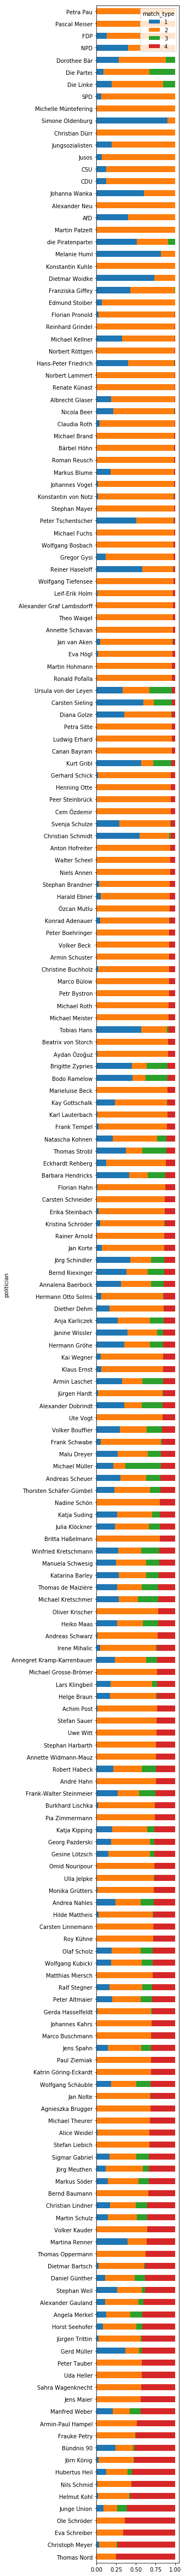

In [9]:
########################
###Data Quality Check###
########################
fig, ax = plt.subplots(figsize=(3,100))
fig.subplots_adjust(left=0.05, bottom=0.3, right=0.75, top=0.95,
                wspace=None, hspace=None)
df1 = pd.crosstab(df['politician'], df['match_type'], rownames=['politician'], colnames=['match_type'])
totals = df1.sum(axis=1)
df2 = df1.loc[:, :].div(totals, axis=0)
df2 = df2.sort_values(ascending=False, by=['4'])
myplot = df2.plot(kind='barh', stacked=True, ax=ax)

2457
Söders


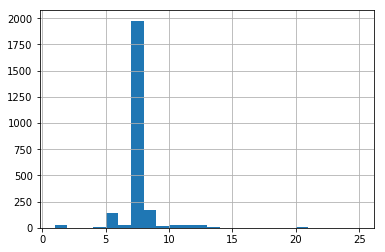

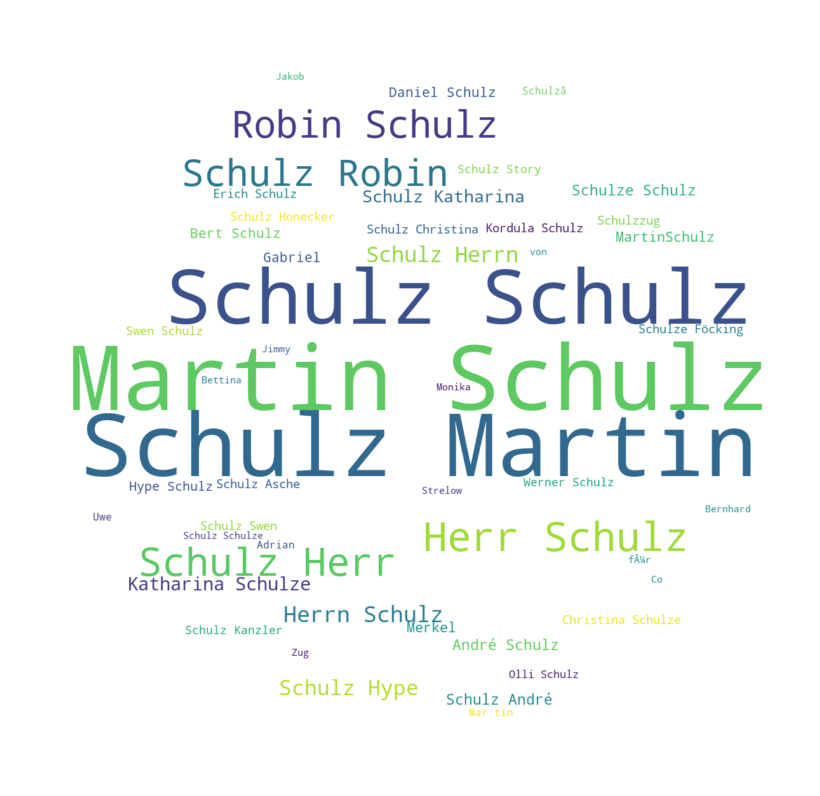

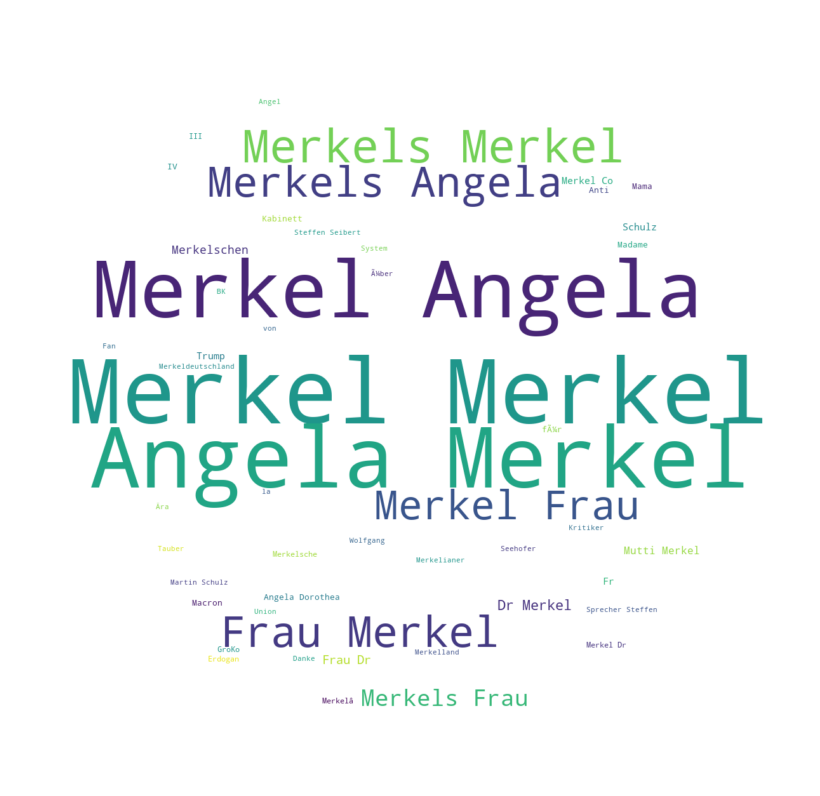

In [10]:
##############################
###Helper for manual checks###
##############################

def levhist(politician, match_type):
    global df
    mydf = df[(df['politician'] == politician) & (df['match_type'] == match_type)]
    mydf.levenshtein.hist(bins =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
    return mydf[mydf.levenshtein > 0].entity_text
mylist = levhist('Markus Söder','4')
print(len(mylist))
print(mylist[10])

# Libraries
from wordcloud import WordCloud
import multidict as multidict

def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        #if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
        #    continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

def gettexts(politician):
    global df
    mydf = df[(df['politician'] == politician)]
    text = ""
    for elem in mydf.entity_text:
        if len(elem)<50:
            text = text + "\w[\w]+" + elem
    return text

def createWordcloud(politician):
    text = gettexts(politician)
    fulltermdict = getFrequencyDictForText(text)
    # Create the wordcloud object
    x, y = np.ogrid[:1200, :1200]
    mask = (x - 600) ** 2 + (y - 600) ** 2 > 560 ** 2
    mask = 255 * mask.astype(int)

    wordcloud = WordCloud(width=1200, height=1200, margin=0, background_color="white",
                          regexp="\w[\w]+", max_words=50, max_font_size=300, prefer_horizontal=1,
                          mask=mask)
    wordcloud.generate(text)
    
    wordcloud.to_file(outputpath + "wordcloud_" + politician + ".png")

    #wordcloud.generate_from_frequencies(fulltermdict)
    fig, ax = plt.subplots(figsize=(14,14))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                        wspace=None, hspace=None)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    
createWordcloud('Martin Schulz')
createWordcloud('Angela Merkel')

In [11]:
##########################
###Data Preprocessing 4###
##########################

#Remove remaining surname matches if manual check showed poor data quality

print("Sentiments before processing: " + str(len(df)))

rsmp1 = ['Christoph Meyer','Thomas Nord','Nils Schmid','Jörn König','Jens Maier','Uda Heller', 'Gerd Müller',
         'Martina Renner','Bernd Baumann','Johannes Kahrs','Pia Zimmermann','Andreas Schwarz','Uwe Witt',
         'Stefan Sauer','Achim Post','Helge Braun','Andreas Schwarz','Nadine Schön','Michael Müller',
         'Kay Gottschalk','Florian Hahn','Jan Korte','Jan Nolte']

rsmp2 = ['Die Partei','Stephan Weil','Michael Kretschmer',
    'Johannes Kahrs','Marco Buschmann','Stefan Liebich','Manfred Weber',
    'Bündnis 90','Hubertus Heil','Ole Schröder','Helmut Kohl','Daniel Günther','Dietmar Bartsch']

for pol in rsmp1:
    print("Removing surnamematches: " + pol)
    df = df[(df['match_type'] == '2') | (df['match_type'] == '1') | (df['politician'] != pol)]

for pol in rsmp2:
    print("Removing surnamematches: " + pol)
    df = df[(df['match_type'] == '2') | (df['match_type'] == '1') | (df['levenshtein'] < 5) | (df['politician'] != pol)]

#Martin Schulz-Special
exclude = ['Robin Schulz','ADRIAN SCHULZ', 'Max Schulz', 'Bert Schulz']
for name in exclude:
    print("Removing Schulz: " + name)
    df = df[df['entity_text'] != name]

#Die Partei
df = df[df['politician'] != 'Die Partei']

print("Sentiments after processing: " + str(len(df)))

Sentiments before processing: 793847
Removing surnamematches: Christoph Meyer
Removing surnamematches: Thomas Nord
Removing surnamematches: Nils Schmid
Removing surnamematches: Jörn König
Removing surnamematches: Jens Maier
Removing surnamematches: Uda Heller
Removing surnamematches: Gerd Müller
Removing surnamematches: Martina Renner
Removing surnamematches: Bernd Baumann
Removing surnamematches: Johannes Kahrs
Removing surnamematches: Pia Zimmermann
Removing surnamematches: Andreas Schwarz
Removing surnamematches: Uwe Witt
Removing surnamematches: Stefan Sauer
Removing surnamematches: Achim Post
Removing surnamematches: Helge Braun
Removing surnamematches: Andreas Schwarz
Removing surnamematches: Nadine Schön
Removing surnamematches: Michael Müller
Removing surnamematches: Kay Gottschalk
Removing surnamematches: Florian Hahn
Removing surnamematches: Jan Korte
Removing surnamematches: Jan Nolte
Removing surnamematches: Die Partei
Removing surnamematches: Stephan Weil
Removing surnamem

In [12]:
##########################
###Data Preprocessing 5###
##########################

#Remove Entity types with poor quality
print("Sentiments before processing: " + str(len(df)))

alltypes = df.groupby(['entity_type']).count()
print(alltypes['sentiment'].head(10))

def getTextForType(entity_type):
    global df
    print(df[df['entity_type'] == entity_type]['entity_text'][1:10])

getTextForType('EmailAddress')
getTextForType('Facility')
getTextForType('GeographicFeature')
getTextForType('Hashtag')
getTextForType('JobTitle')
getTextForType('Location')
getTextForType('Organization')
getTextForType('Person')
getTextForType('TwitterHandle')
getTextForType('URL')

df = df[df['entity_type'] != 'Facility']
df = df[df['entity_type'] != 'Location']
df = df[df['entity_type'] != 'URL']

print("Sentiments after processing: " + str(len(df)))

Sentiments before processing: 746498
entity_type
EmailAddress             41
Facility                 83
GeographicFeature       159
Hashtag                 959
JobTitle                378
Location               4166
Organization         318033
Person               421916
TwitterHandle           632
URL                     131
Name: sentiment, dtype: int64
index
2018-03-17                «@afd-bw.de
2018-03-11         spahn@bundestag.de
2018-02-27    sk@bayernspd-landtag.de
2018-02-24                  @jusos.de
2018-02-22                  @jusos.de
2018-02-22              Name@jusos.de
2018-02-22              Name@jusos.de
2018-02-22                 „@jusos.de
2018-02-21                  @jusos.de
Name: entity_text, dtype: object
index
2018-04-13                         Öko-Söder
2018-04-01    linke Szeneobjekt, Haus Nr. 94
2018-03-28                Leyen Gedenkstätte
2018-03-18               BER schloss Scheuer
2018-03-16                 Nockherberg-Söder
2018-03-11               BER 

In [13]:
##################################
###Save Preprocessed Sentiments###
##################################

df.to_csv(outputpath + 'preprocessedsentiments.csv', sep=';')